In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 0.13.2 -> algoritma yang digunakan untuk pembelajaran sudah deprecated

In [ ]:
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 3.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2


In [ ]:
import statsmodels as sm

In [ ]:
!python --version

Python 3.7.13


In [ ]:
sm.__version__

'0.12.2'

## **Latihan Time Series (ARIMA)**

**Gunakan dataset AirPassengers**

1. Lakukan EDA.
2. Cek apakah data sudah stasioner? Jika belum, lakukan differencing.
3. Gunakan ADF test untuk mengecek stasioneritas data secara perhitungan statistik.
4. Cari model ARIMA terbaik melalui grafik ACF & PACF.
5. Buat modelnya dan lakukan forecasting untuk periode 1 tahun.

ARIMA<br>
AR = Autoregressive / p / ACF tails off PACF Cut Off after lag?<br>
I = Integrated /d / differencing order until stationary reached<br>
MA = Moving Average / q / ACF Cut Off after lag? PACF tails off<br>

Both ACF and PACF tails off -> ARIMA<br>

Both ACF and PACF cut off after certain lag -> AR I / I MA

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

* https://www.statsmodels.org/v0.12.2/generated/statsmodels.tsa.arima_model.ARIMA.html?highlight=arima#statsmodels.tsa.arima_model.ARIMA
* https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
* https://machinelearningmastery.com/time-series-data-stationary-python/

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/JCDSVL-04, 06, JCDSAHLS-01 Practice Session/Modul 3/Week 9/Thursday, July 21, 2022/AirPassengers.csv') # AirPassengers.csv
df

,TravelDate,Passengers
0,1/1/1949,112
1,2/1/1949,118
2,3/1/1949,132
3,4/1/1949,129
4,5/1/1949,121
...,...,...
139,8/1/1960,606
140,9/1/1960,508
141,10/1/1960,461
142,11/1/1960,390


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TravelDate  144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df = df.rename(columns={'TravelDate': 'Date'})

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['Date'] = df['Date'].dt.date

## **EDA**

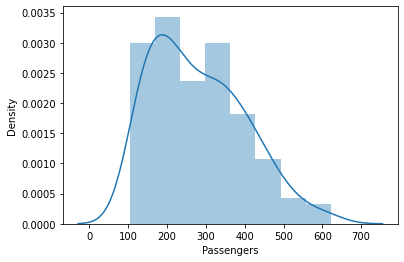

In [ ]:
sns.distplot(df['Passengers']);

In [ ]:
df['Passengers'].skew()

0.5831604861560892

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name='true', x=df['Date'], y=df['Passengers'])])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## **Stationarity**

### **Cek stationarity dengan menggunakan adfuller test**

**Hypothesis untuk adfuller test:**

$H_0$: Data tidak stasioner

$H_1$: Data stasioner

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br>
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

* https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html

In [ ]:
adf = adfuller(df['Passengers'])
adf

(0.8153688792060472,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.578770059171598,
  '5%': -2.8840418343195267},
 996.6929308390189)

In [ ]:
adf = adfuller(df['Passengers'])
print(adf)

alpha = 0.05
if adf[1] <= alpha:
    print('Reject null hypothesis, The data is stationary')
else:
    print('Failed to reject null hypothesis, The data is not stationary')

(0.8153688792060472, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
Failed to reject null hypothesis, The data is not stationary


In [ ]:
# buat DataFrame untuk data yang stasioner
df_stationary = df.copy()

In [ ]:
# differencing 1 kali
df_stationary['Passengers_Stationary'] = df_stationary['Passengers'].diff()

# differencing 2 kali
df_stationary['Passengers_Stationary_2'] = df_stationary['Passengers'].diff().diff()

In [ ]:
df_stationary

,Date,Passengers,Passengers_Stationary,Passengers_Stationary_2
0,1949-01-01,112,NaN,NaN
1,1949-02-01,118,6.0,NaN
2,1949-03-01,132,14.0,8.0
3,1949-04-01,129,-3.0,-17.0
4,1949-05-01,121,-8.0,-5.0
...,...,...,...,...
139,1960-08-01,606,-16.0,-103.0
140,1960-09-01,508,-98.0,-82.0
141,1960-10-01,461,-47.0,51.0
142,1960-11-01,390,-71.0,-24.0


In [ ]:
# drop baris pertama dan kedua
df_stationary = df_stationary.dropna()

In [ ]:
# Dataframe untuk modeling
df_stationary

,Date,Passengers,Passengers_Stationary,Passengers_Stationary_2
2,1949-03-01,132,14.0,8.0
3,1949-04-01,129,-3.0,-17.0
4,1949-05-01,121,-8.0,-5.0
5,1949-06-01,135,14.0,22.0
6,1949-07-01,148,13.0,-1.0
...,...,...,...,...
139,1960-08-01,606,-16.0,-103.0
140,1960-09-01,508,-98.0,-82.0
141,1960-10-01,461,-47.0,51.0
142,1960-11-01,390,-71.0,-24.0


In [ ]:
# cek setelah dilakukan differencing 1x apakah sudah stasioner

adf_stat = adfuller(df_stationary['Passengers_Stationary'])
print(adf_stat)

alpha = 0.05
if adf_stat[1] <= alpha:
    print('Reject null hypothesis; The data is stationary')
else:
    print('Failed to reject null hypothesis; The data is not stationary')

(-2.833425645565324, 0.053655499158909006, 12, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, 980.990262745086)
Failed to reject null hypothesis; The data is not stationary


In [ ]:
# cek setelah dilakukan differencing 2x apakah sudah stasioner

adf_stat = adfuller(df_stationary['Passengers_Stationary_2'])
print(adf_stat)

alpha = 0.05
if adf_stat[1] <= alpha:
    print('Reject null hypothesis; The data is stationary')
else:
    print('Failed to reject null hypothesis; The data is not stationary')

(-16.384231542468495, 2.7328918500143186e-29, 11, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.6020417275602)
Reject null hypothesis; The data is stationary


**Data sudah stasioner setelah 2 kali differencing**

Differencing dilakukan agar data menjadi stasioner

### **Cek stationarity dengan menggunakan grafik ACF dan PACF**


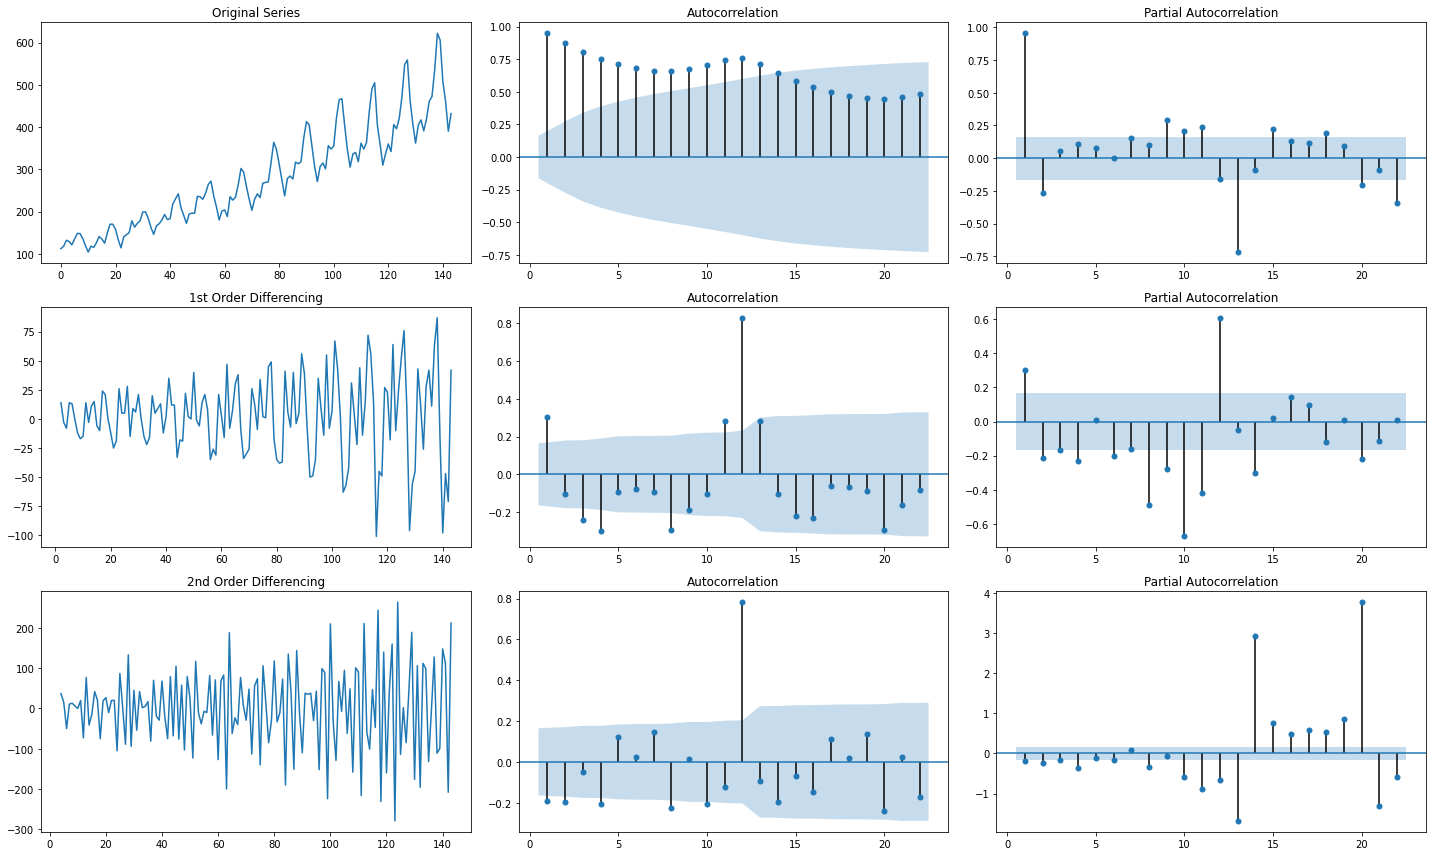

In [ ]:
fig, axes = plt.subplots(3, 3, figsize = (20,12))

# Original Series
axes[0, 0].plot(df['Passengers']);
axes[0, 0].set_title('Original Series')
plot_acf(df['Passengers'], ax=axes[0, 1], zero = False)
plot_pacf(df['Passengers'], ax=axes[0, 2], zero = False)

# 1st Differencing
axes[1, 0].plot(df_stationary['Passengers_Stationary']);
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_stationary['Passengers_Stationary'].dropna(), ax=axes[1, 1], zero = False)
plot_pacf(df_stationary['Passengers_Stationary'].dropna(), ax=axes[1, 2], zero = False)

# 2nd Differencing
axes[2, 0].plot(df_stationary['Passengers_Stationary_2'].diff().diff());
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_stationary['Passengers_Stationary_2'].dropna(), ax=axes[2, 1], zero = False)
plot_pacf(df_stationary['Passengers_Stationary_2'].dropna(), ax=axes[2, 2], zero = False)

plt.tight_layout()
plt.show()

**Interpretasi**

- Pada original series, grafik ACF (Autocorrelation) masih slowly tail-off. Artinya datanya tidak stasioner
- Kita lakukan differencing orde ke-1.
- Jika melihat dari grafik ACF (Autocorrelation) yang tidak lagi slowly tail-off, data terlihat sudah stasioner pada differensing orde ke-1.
- Kita coba lihat juga ketika dilakukan differenceing orde ke-2
- Datanya juga sudah terlihat stasioner.  

## **Modeling**

- Penentuan model ARIMA bisa dilakukan secara manual dengan melihat pada grafik ACF dan PACF di atas. Penentuannya secara subjektif.
- Jika melihat dari grafik ACF dn PACF, data stasioner pada differencing orde ke-1. Berarti d=1.
- Lihat grafik ACF. Bar pertama yang ada di luar zona biru (confidence interval) dipilih sebagai q (MA). Berarti q=1
- Lihat grafik PACF. Bar pertama yang ada di luar zona biru (confidence interval) dipilih sebagai p (AR). Berarti p=1

Grafik ACF cut-off, grafik PACF juga cut-off. Jadi kandidatnya adalah
- ARIMA (p, d, q) = (1,2,0)
- **ARIMA (p, d, q) = (0,2,1)**

> <br>
> Model Specification (stationary condition) :

> - PACF Cut off after lag p, ACF Tails Off --> AR(p)
> - ACF Cut off after lag q, PACF Tails Off --> MA(q)
> - PACF Cut off after lag p, ACF Cut off after lag q --> AR(p) or MA(q)
> - ACF and PACF tails off -->  choose all possible combination

> <br>

Bisa juga kita mencari model ARIMA terbaik secara otomatis menggunakan auto_arima dari pmdarima. Nilai AIC paling kecil menunjukkan model terbaik.

* https://alkaline-ml.com/pmdarima/

In [ ]:
!pip install pmdarima
import pmdarima as pmd

# arima_model = pmd.auto_arima(
#     df_stationary['Passengers_Stationary_2'],
#     start_p=1,
#     start_q=1,
#     trace=True
# )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
arima_model = pmd.auto_arima(
    df_stationary['Passengers'],
    start_p=1,
    start_q=1,
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1378.648, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1397.391, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1385.745, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1381.200, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1395.947, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1380.880, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1380.391, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1377.155, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1379.584, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1384.074, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1360.865, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1378.9

**Contoh kandidat model:**
<!--
1. ARIMA(2, 2, 2)
2. ARIMA(4, 2, 2) -->

**Contoh kandidat model:**
1. ARIMA(0, 2, 1)
2. ARIMA(5, 1, 4)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# model = ARIMA(df['Passengers'], order = (2, 2, 2))
# model_fit = model.fit()

# print(model_fit.summary())

In [ ]:
model = ARIMA(df['Passengers'], order = (0, 2, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D2.Passengers   No. Observations:                  142
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -703.681
Method:                       css-mle   S.D. of innovations             33.754
Date:                Wed, 20 Jul 2022   AIC                           1413.363
Time:                        10:17:43   BIC                           1422.230
Sample:                             2   HQIC                          1416.966
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0049      0.068     -0.072      0.943      -0.139       0.129
ma.L1.D2.Passengers    -1.0000      0.018    -55.615      0.000      -1.035      -0.965
                

In [ ]:
model2 = ARIMA(df['Passengers'], order = (5, 1, 4))
model2_fit = model2.fit()
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -660.600
Method:                       css-mle   S.D. of innovations             23.605
Date:                Wed, 20 Jul 2022   AIC                           1343.200
Time:                        10:17:46   BIC                           1375.791
Sample:                             1   HQIC                          1356.443
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6792      0.122     21.876      0.000       2.439       2.919
ar.L1.D.Passengers    -0.5022      0.112     -4.496      0.000      -0.721      -0.283
ar.L2.D.Passengers  

## **Forecasting**
sama seperti predict

In [ ]:
# prediksi jumlah passenger 12 bulan ke depan (sepanjang tahun 1961)

forecast_length = 12
forecast_result = model2_fit.forecast(forecast_length)
forecast_result

(array([490.72087504, 478.45148015, 509.32574419, 508.43805991,
        479.37969845, 484.43864073, 495.35305419, 475.18943639,
        493.40571186, 508.33185257, 493.85185193, 505.24915901]),
 array([23.60515728, 36.82296941, 42.16464775, 43.24650669, 43.74398408,
        44.41092625, 44.88080885, 45.26773302, 45.26818177, 45.42473366,
        45.43149958, 45.4769129 ]),
 array([[444.45561693, 536.98613316],
        [406.27978629, 550.623174  ],
        [426.68455317, 591.96693521],
        [423.67646434, 593.19965548],
        [393.64306511, 565.11633179],
        [397.39482477, 571.4824567 ],
        [407.38828524, 583.31782314],
        [386.46631001, 563.91256276],
        [404.68170594, 582.12971778],
        [419.30101058, 597.36269455],
        [404.80774898, 582.89595487],
        [416.11604761, 594.38227042]]))

In [ ]:
print('Forecasted Value', '\n', forecast_result[0], '\n')
print('Forecasted SE', '\n', forecast_result[1], '\n')
print('Forecasted confidence interval', '\n', forecast_result[2])

Forecasted Value 
 [490.72087504 478.45148015 509.32574419 508.43805991 479.37969845
 484.43864073 495.35305419 475.18943639 493.40571186 508.33185257
 493.85185193 505.24915901] 

Forecasted SE 
 [23.60515728 36.82296941 42.16464775 43.24650669 43.74398408 44.41092625
 44.88080885 45.26773302 45.26818177 45.42473366 45.43149958 45.4769129 ] 

Forecasted confidence interval 
 [[444.45561693 536.98613316]
 [406.27978629 550.623174  ]
 [426.68455317 591.96693521]
 [423.67646434 593.19965548]
 [393.64306511 565.11633179]
 [397.39482477 571.4824567 ]
 [407.38828524 583.31782314]
 [386.46631001 563.91256276]
 [404.68170594 582.12971778]
 [419.30101058 597.36269455]
 [404.80774898 582.89595487]
 [416.11604761 594.38227042]]


In [ ]:
df.tail(6)

,Date,Passengers
138,1960-07-01,622
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


In [ ]:
# membuat tanggal untuk hasil forecasting
Month = []

for i in range(1, forecast_length+1):
    Month.append('1961-'+str(i)+'-01')

Month

['1961-1-01',
 '1961-2-01',
 '1961-3-01',
 '1961-4-01',
 '1961-5-01',
 '1961-6-01',
 '1961-7-01',
 '1961-8-01',
 '1961-9-01',
 '1961-10-01',
 '1961-11-01',
 '1961-12-01']

In [ ]:
df_forecast = pd.DataFrame({
    'Date': Month,
    'Passengers': forecast_result[0],
})

df_forecast

,Date,Passengers
0,1961-1-01,490.720875
1,1961-2-01,478.451480
2,1961-3-01,509.325744
3,1961-4-01,508.438060
4,1961-5-01,479.379698
5,1961-6-01,484.438641
6,1961-7-01,495.353054
7,1961-8-01,475.189436
8,1961-9-01,493.405712
9,1961-10-01,508.331853


In [ ]:
# Hasil forecasting

df_forecast['SE'] = forecast_result[1]
df_forecast['Lower Bound'] = forecast_result[2][:,0]
df_forecast['Upper Bound'] = forecast_result[2][:,1]
df_forecast

,Date,Passengers,SE,Lower Bound,Upper Bound
0,1961-1-01,490.720875,23.605157,444.455617,536.986133
1,1961-2-01,478.451480,36.822969,406.279786,550.623174
2,1961-3-01,509.325744,42.164648,426.684553,591.966935
3,1961-4-01,508.438060,43.246507,423.676464,593.199655
4,1961-5-01,479.379698,43.743984,393.643065,565.116332
5,1961-6-01,484.438641,44.410926,397.394825,571.482457
6,1961-7-01,495.353054,44.880809,407.388285,583.317823
7,1961-8-01,475.189436,45.267733,386.466310,563.912563
8,1961-9-01,493.405712,45.268182,404.681706,582.129718
9,1961-10-01,508.331853,45.424734,419.301011,597.362695


In [ ]:
# df_forecast.iloc[:12,:][['Date', 'Passengers']]

In [ ]:
df_forecast.iloc[:1,:][['Date', 'Passengers']]

,Date,Passengers
0,1961-1-01,490.720875


In [ ]:
# agar garis dataset awal dan garis hasil forcasting tersambung
df = df.append(df_forecast.iloc[:1,:][['Date', 'Passengers']])

In [ ]:
df.iloc[-7:, :]

,Date,Passengers
138,1960-07-01,622.000000
139,1960-08-01,606.000000
140,1960-09-01,508.000000
141,1960-10-01,461.000000
142,1960-11-01,390.000000
143,1960-12-01,432.000000
0,1961-1-01,490.720875


In [ ]:
# Gabungan dari dataset awal dan hasil forecasting

# df_merged = df
# df_merged = df_merged.append(df_forecast.iloc[:12,:][['Date', 'Passengers']], ignore_index=True)
# df_merged.tail(24)

In [ ]:
# lineplot dataset awal
fig = go.Figure([go.Scatter(name='Actual', x=df['Date'], y=df['Passengers'])])

# lineplot hasil forecasting
fig.add_trace(go.Scatter(name='Forecast', x=df_forecast['Date'], y=df_forecast['Passengers']))     # forecast
fig.add_trace(go.Scatter(name='Lower Bound', x=df_forecast['Date'], y=df_forecast['Lower Bound']))
fig.add_trace(go.Scatter(name='Upper Bound', x=df_forecast['Date'], y=df_forecast['Upper Bound']))

fig.update_xaxes(rangeslider_visible = True)
fig.show()

## **Latihan Text Mining**<br>
### **Gunakan dataset spam_or_not_spam**


* Preprocess data, gunakan lemmatization dan TF-IDF sebagai bagian dari preprocessing.  
* Lakukan eksplorasi data dengan menampilkan:
    - words frequency
    - wordcloud  
    - sentences length dari spam vs not spam.     
* Untuk text classification, coba gunakan model logistic regression.
* Lakukanlah tuning pada model tersebut, lalu bandingkan hasil sebelum dan sesudah tuning.